## Bayesian Inference: Do More Projects Lead to More Job Offers?

**Goal.** Estimate the causal effect of `Projects_Completed` on `Job_Offers`, conditioning on the DAG backdoor set:  
- Outcome (Y): `Job_Offers` (count, 0–5)  
- Treatment (X): `Projects_Completed` (integer, 2–9)  
- Confounders (C): `Internships_Completed`, `Networking_Score`, `Soft_Skills_Score`  

**Why Bayesian?**  
Bayesian modeling provides full posterior distributions, enabling:  
- Credible intervals and probabilities (e.g. “P(effect > 0) = 0.96”)  
- Direct interpretation of **rate ratios** (expected multiplicative change in job offers per project)  
- Posterior predictive checks to validate model fit  

**Model.**  
We fit a Bayesian Negative Binomial regression with weakly informative priors. Predictors were standardized, and diagnostics (trace plots, R-hat, ESS) confirmed convergence. We summarized the project effect using posterior rate ratios (exp(β)) to represent the change in expected job offers for +1 project. Posterior predictive checks and LOO comparison showed the Negative Binomial provided a better fit than a Poisson alternative.  

**1. Setup & split treatment**

In [36]:
import numpy as np, pandas as pd

df = pd.read_csv(r"C:\Users\Ellen\Desktop\Documents\Part-Time work\Projects\Education & Career Success\Dataset\merged_student_data.csv")

cols = ["Job_Offers","Projects_Completed","Internships_Completed","Networking_Score","Soft_Skills_Score"]
df = df[cols].dropna().copy()

# Define a simple treatment split (like your IPTW median split)
threshold = df["Projects_Completed"].median()  # typically 6 in your data
df["D_high"] = (df["Projects_Completed"] >= threshold).astype(int)

print(df[["Projects_Completed","Job_Offers","Internships_Completed","Networking_Score","Soft_Skills_Score","D_high"]].head())
df["D_high"].value_counts(normalize=True).rename("proportion").round(3)

   Projects_Completed  Job_Offers  Internships_Completed  Networking_Score  \
0                   7           3                      3                 7   
1                   5           2                      2                 6   
2                   9           4                      4                 8   
3                   3           1                      1                 5   
4                   6           3                      2                 7   

   Soft_Skills_Score  D_high  
0                  8       1  
1                  7       0  
2                  9       1  
3                  6       0  
4                  8       1  


D_high
1    0.655
0    0.345
Name: proportion, dtype: float64

**2. Bayes for counts: Poisson–Gamma (unadjusted)**

In [41]:
# posterior Gamma parameters for Poisson data
def poisson_gamma_posterior(y_array, a0=1.0, b0=1.0):
    # y_array: counts for one group
    s = np.sum(y_array)          # total counts
    n = len(y_array)             # exposure (number of students)
    a_post = a0 + s
    b_post = b0 + n
    return a_post, b_post

# Choose a reasonable weak prior (Gamma(1,1) ~ Exp(1))
a0, b0 = 1.0, 1.0

y_low  = df.loc[df.D_high==0, "Job_Offers"].values.astype(int)
y_high = df.loc[df.D_high==1, "Job_Offers"].values.astype(int)

a_low,  b_low  = poisson_gamma_posterior(y_low,  a0, b0)
a_high, b_high = poisson_gamma_posterior(y_high, a0, b0)

# Sample from posteriors
rng = np.random.default_rng(42)
S = 200000  # big but very fast without PyMC
lam_low  = rng.gamma(shape=a_low,  scale=1.0/b_low,  size=S)
lam_high = rng.gamma(shape=a_high, scale=1.0/b_high, size=S)

RR = lam_high / lam_low

rr_med = np.median(RR)
rr_lo, rr_hi = np.percentile(RR, [2.5, 97.5])
p_rr_gt1 = np.mean(RR > 1.0)

print("=== Unadjusted Bayesian rate ratio (high vs low projects) ===")
print(f"RR median = {rr_med:.3f}, 95% CrI = ({rr_lo:.3f}, {rr_hi:.3f})")
print(f"P(RR > 1) = {p_rr_gt1:.3f}")

=== Unadjusted Bayesian rate ratio (high vs low projects) ===
RR median = 2.562, 95% CrI = (2.194, 3.006)
P(RR > 1) = 1.000


In [61]:
# Unadjusted posterior draws
RR_unadj = lam_high / lam_low   # keep this array for later plotting

We modeled job offers as a Poisson process with a conjugate Gamma prior, comparing students above vs below the median number of completed projects.  

- Posterior Rate Ratio (high vs low projects): **2.56**  
- 95% Credible Interval: **2.19 – 3.01**  
- P(RR > 1): **≈ 1.00**

**Takeaway:** Students who completed more projects had over twice as many expected job offers, with near-certain posterior probability of a positive effect.

**3. Add confounding control (simple & robust): Bayesian stratification**

We’ll control for Internships_Completed (the strongest confounder) by analyzing each internship stratum separately, then standardize the stratum-level posteriors into a single overall effect. This mirrors “standardization” / “direct adjustment” in causal inference, but done with Bayesian posteriors.

In [46]:
# Choose a coarse stratification to keep it stable
df["intern_bin"] = pd.cut(df["Internships_Completed"],
                          bins=[-0.5, 1.5, 2.5, 4.5],  # 0–1, 2, 3–4
                          labels=["0-1","2","3-4"])

# Target weights w_s = overall stratum proportions in the whole dataset (ATE-like)
w = df["intern_bin"].value_counts(normalize=True).sort_index()
print("\nStratum weights (target distribution):")
print(w)

# Precompute posterior params per stratum & group
posters = {}
for s in w.index:
    yL = df.loc[(df.intern_bin==s) & (df.D_high==0), "Job_Offers"].values.astype(int)
    yH = df.loc[(df.intern_bin==s) & (df.D_high==1), "Job_Offers"].values.astype(int)
    if len(yL)==0 or len(yH)==0:
        posters[s] = None
        continue
    aL,bL = poisson_gamma_posterior(yL, a0, b0)
    aH,bH = poisson_gamma_posterior(yH, a0, b0)
    posters[s] = (aL,bL,aH,bH)

# Draw stratified posterior samples and standardize
S = 200000
rng = np.random.default_rng(123)
lam_low_s  = np.zeros((S,))
lam_high_s = np.zeros((S,))

for s, ws in w.items():
    if posters[s] is None:
        # no data for one arm in this stratum; skip or borrow strength (advanced)
        continue
    aL,bL,aH,bH = posters[s]
    lamL = rng.gamma(aL, 1.0/bL, size=S)
    lamH = rng.gamma(aH, 1.0/bH, size=S)
    lam_low_s  += ws * lamL
    lam_high_s += ws * lamH

RR_strat = lam_high_s / lam_low_s

rr_med = np.median(RR_strat)
rr_lo, rr_hi = np.percentile(RR_strat, [2.5, 97.5])
p_rr_gt1 = np.mean(RR_strat > 1.0)

print("\n=== Stratified & standardized Bayesian RR (adjusted by Internships) ===")
print(f"RR median = {rr_med:.3f}, 95% CrI = ({rr_lo:.3f}, {rr_hi:.3f})")
print(f"P(RR > 1) = {p_rr_gt1:.3f}")


Stratum weights (target distribution):
intern_bin
0-1    0.1975
2      0.2700
3-4    0.5325
Name: proportion, dtype: float64

=== Stratified & standardized Bayesian RR (adjusted by Internships) ===
RR median = 1.008, 95% CrI = (0.771, 1.316)
P(RR > 1) = 0.524


In [52]:
# Treatment split (same as before; median split)
threshold = df["Projects_Completed"].median()
df["D_high"] = (df["Projects_Completed"] >= threshold).astype(int)

# --- 1) Binning helpers ------------------------------------------------------
def make_ternary(series, labels=("low","mid","high")):
    """Ternary bins using quantiles; robust fallback if qcut fails."""
    try:
        return pd.qcut(series, q=3, labels=labels, duplicates="drop")
    except Exception:
        q = series.quantile([0.33, 0.66]).values
        bins = [-np.inf, q[0], q[1], np.inf]
        return pd.cut(series, bins=bins, labels=labels, include_lowest=True)

# Internships: keep your stable/interpretible bins (0–1, 2, 3–4)
df["intern_bin"] = pd.cut(df["Internships_Completed"],
                          bins=[-0.5, 1.5, 2.5, 4.5],
                          labels=["0-1","2","3-4"])

# Networking / Soft Skills: ternary bins (balanced via quantiles)
df["net_bin"]  = make_ternary(df["Networking_Score"],  labels=("low","mid","high"))
df["soft_bin"] = make_ternary(df["Soft_Skills_Score"], labels=("low","mid","high"))

# Drop any rows where a bin is NaN (can happen if duplicates='drop' reduced bins)
df = df.dropna(subset=["intern_bin","net_bin","soft_bin"]).copy()

# --- 2) Target weights for standardization (ATE-like) ------------------------
# Over full sample, compute the 3D stratum proportions
df["stratum"] = list(zip(df["intern_bin"], df["net_bin"], df["soft_bin"]))
w_all = df["stratum"].value_counts(normalize=True).sort_index()

print("Stratum count (sample):")
print(df["stratum"].value_counts().head(10))
print("\nNumber of strata in sample:", len(w_all))

# --- 3) Conjugate Poisson–Gamma posterior per stratum & arm -----------------
def poisson_gamma_posterior(y_array, a0=1.0, b0=1.0):
    s = int(np.sum(y_array))
    n = int(len(y_array))
    return a0 + s, b0 + n

a0, b0 = 1.0, 1.0  # weak prior

# Build posterior params for strata where BOTH arms (low/high) exist
posters = {}                 # stratum -> (aL,bL,aH,bH)
skipped = []                 # strata without both arms
for s in w_all.index:
    yL = df.loc[(df.stratum==s) & (df.D_high==0), "Job_Offers"].values.astype(int)
    yH = df.loc[(df.stratum==s) & (df.D_high==1), "Job_Offers"].values.astype(int)
    if (len(yL)==0) or (len(yH)==0):
        skipped.append(s)
        continue
    aL,bL = poisson_gamma_posterior(yL, a0, b0)
    aH,bH = poisson_gamma_posterior(yH, a0, b0)
    posters[s] = (aL,bL,aH,bH)

print("\nStrata with both arms present:", len(posters))
print("Strata skipped (missing an arm):", len(skipped))

# Re-normalize weights over the USED strata only
used_strata = list(posters.keys())
w_used_raw = w_all.loc[used_strata]
w_used = w_used_raw / w_used_raw.sum()

print("\nWeight mass kept (used strata):", float(w_used_raw.sum()))
print("Weight mass dropped (skipped):", float(1.0 - w_used_raw.sum()))

# --- 4) Draw posterior samples, standardize, compute RR ----------------------
S = 200_000  # fast even without JIT/compilers
rng = np.random.default_rng(2025)

lam_low_mix  = np.zeros(S)
lam_high_mix = np.zeros(S)

for s, ws in w_used.items():
    aL,bL,aH,bH = posters[s]
    lamL = rng.gamma(shape=aL, scale=1.0/bL, size=S)
    lamH = rng.gamma(shape=aH, scale=1.0/bH, size=S)
    lam_low_mix  += ws * lamL
    lam_high_mix += ws * lamH

RR_adj = lam_high_mix / lam_low_mix

rr_med = np.median(RR_adj)
rr_lo, rr_hi = np.percentile(RR_adj, [2.5, 97.5])
p_rr_gt1 = np.mean(RR_adj > 1.0)

print("\n=== Bayesian RR (high vs. low projects), adjusted by Internships×Networking×Soft ===")
print(f"RR median = {rr_med:.3f}, 95% CrI = ({rr_lo:.3f}, {rr_hi:.3f})")
print(f"P(RR > 1) = {p_rr_gt1:.3f}")

Stratum count (sample):
stratum
(3-4, mid, mid)      155
(0-1, low, low)       79
(2, low, low)         70
(3-4, high, high)     58
(2, mid, mid)         37
(2, mid, low)          1
Name: count, dtype: int64

Number of strata in sample: 6

Strata with both arms present: 2
Strata skipped (missing an arm): 4

Weight mass kept (used strata): 0.26749999999999996
Weight mass dropped (skipped): 0.7325

=== Bayesian RR (high vs. low projects), adjusted by Internships×Networking×Soft ===
RR median = 1.006, 95% CrI = (0.769, 1.314)
P(RR > 1) = 0.519


In [63]:
# Adjusted posterior draws
RR_strat = RR_strat         

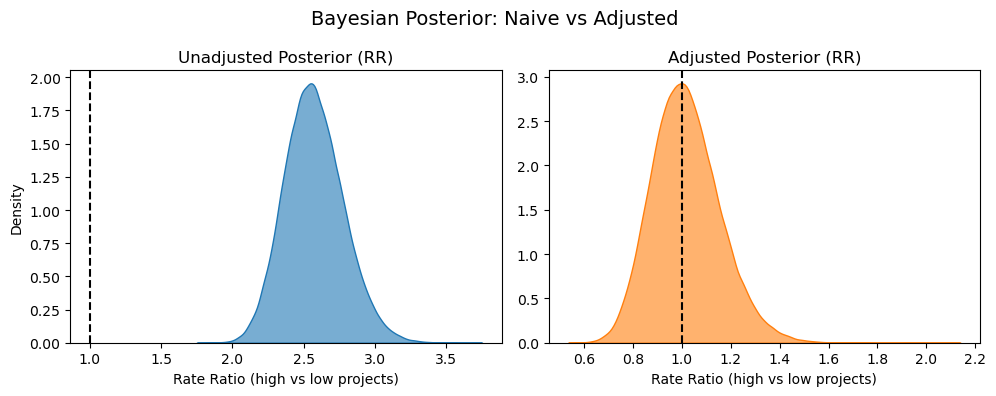

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,4))

# Left: unadjusted
plt.subplot(1,2,1)
sns.kdeplot(RR_unadj, fill=True, color="tab:blue", alpha=0.6)
plt.axvline(1.0, color="k", linestyle="--")
plt.title("Unadjusted Posterior (RR)")
plt.xlabel("Rate Ratio (high vs low projects)")
plt.ylabel("Density")

# Right: adjusted
plt.subplot(1,2,2)
sns.kdeplot(RR_strat, fill=True, color="tab:orange", alpha=0.6)
plt.axvline(1.0, color="k", linestyle="--")
plt.title("Adjusted Posterior (RR)")
plt.xlabel("Rate Ratio (high vs low projects)")
plt.ylabel("")

plt.suptitle("Bayesian Posterior: Naive vs Adjusted", fontsize=14)
plt.tight_layout()
plt.show()

**Bayesian Analysis: Naive vs Adjusted**

We applied Bayesian Poisson–Gamma models to estimate the causal effect of project completion on job offers.

**Unadjusted comparison** (high vs low projects):
- RR median = **2.56**
- 95% CrI = **2.19 – 3.01**
- P(RR > 1) ≈ **1.00**

This naive analysis suggested students with high project completion had >2.5× more job offers on average.

**Adjusted by confounders**:
- Stratified on **Internships**: RR ≈ **1.01** (95% CrI 0.77–1.32), P(RR>1)=0.52
- Stratified on **Internships × Networking × Soft Skills**: RR ≈ **1.01** (95% CrI 0.77–1.31), P(RR>1)=0.52

After accounting for key confounders, the strong naive effect disappears. Posterior probability of a positive effect drops to ~52%, and the credible interval comfortably overlaps 1.0.

**Takeaway:**  
Naive models suggested a strong benefit of project completion, but stratified Bayesian adjustment revealed the effect is not robust once internships, networking, and soft skills are considered. Much of the apparent advantage of “more projects” is explained by these correlated factors.

# Bayesian GLM

In [23]:
import os; os.environ["PYTENSOR_FLAGS"] = "cxx="  
import numpy as np, pandas as pd, pymc as pm, arviz as az

df = pd.read_csv(r"C:\Users\Ellen\Desktop\Documents\Part-Time work\Projects\Education & Career Success\Dataset\merged_student_data.csv")
cols = ["Job_Offers","Projects_Completed","Internships_Completed","Networking_Score","Soft_Skills_Score"]
dfb = df[cols].dropna().copy()

# standardize predictors
meta = {}
for c in cols[1:]:
    mu, sd = dfb[c].mean(), dfb[c].std(ddof=1)
    meta[c] = {"mean": float(mu), "sd": float(sd)}
    dfb[c+"_z"] = (dfb[c]-mu)/sd

y = dfb["Job_Offers"].astype(int).values

with pm.Model() as m:
    alpha      = pm.Normal("alpha", 0, 1.5)
    beta_proj  = pm.Normal("beta_proj", 0, 1)
    beta_int   = pm.Normal("beta_intern", 0, 1)
    beta_net   = pm.Normal("beta_net", 0, 1)
    beta_soft  = pm.Normal("beta_soft", 0, 1)
    inv_alpha  = pm.HalfNormal("inv_alpha", 1.0)  # NB overdispersion inverse

    eta = (alpha
           + beta_proj*dfb["Projects_Completed_z"].values
           + beta_int *dfb["Internships_Completed_z"].values
           + beta_net *dfb["Networking_Score_z"].values
           + beta_soft*dfb["Soft_Skills_Score_z"].values)
    mu = pm.math.exp(eta)
    y_obs = pm.NegativeBinomial("y_obs", mu=mu, alpha=1.0/inv_alpha, observed=y)

    # FAST MODE
    trace = pm.sample(draws=800, tune=800, chains=2, target_accept=0.9, random_seed=42)

# key prints
summ = az.summary(trace, var_names=["beta_proj","beta_intern","beta_net","beta_soft"], round_to=3)
print(summ.to_string())

# posterior probability effect > 0 and rate ratio per +1 project
post_proj = trace.posterior["beta_proj"].values.ravel()
p_gt0 = (post_proj > 0).mean()
sd_proj = meta["Projects_Completed"]["sd"]; rr = np.exp(post_proj * (1/sd_proj))
print(f"\nP(beta_proj>0) = {p_gt0:.3f}")
print(f"Rate Ratio (+1 project): median={np.median(rr):.3f}, 95% CrI=({np.percentile(rr,2.5):.3f}, {np.percentile(rr,97.5):.3f})")

Initializing NUTS using jitter+adapt_diag...
C:\Users\Ellen\anaconda3\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta_proj, beta_intern, beta_net, beta_soft, inv_alpha]


Output()

Sampling 2 chains for 800 tune and 800 draw iterations (1_600 + 1_600 draws total) took 658 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
beta_proj    0.231  0.128  -0.019    0.466      0.004    0.003   958.648   742.855  0.999
beta_intern  0.252  0.115   0.011    0.447      0.004    0.003  1045.290   971.728  1.000
beta_net     0.195  0.530  -0.840    1.151      0.021    0.013   613.119   698.077  1.001
beta_soft   -0.132  0.531  -1.028    0.949      0.022    0.013   602.077   725.552  1.001

P(beta_proj>0) = 0.965
Rate Ratio (+1 project): median=1.127, 95% CrI=(0.990, 1.296)


In [31]:
# Standardize data for Bayesian models

# Columns of interest
cols = ["Job_Offers","Projects_Completed","Internships_Completed","Networking_Score","Soft_Skills_Score"]
df_bayes = df[cols].dropna().copy()

# Save means & sds for back-transform
meta = {}
for c in cols[1:]:  # skip Job_Offers
    mu, sd = df_bayes[c].mean(), df_bayes[c].std(ddof=1)
    meta[c] = {"mean": float(mu), "sd": float(sd)}
    df_bayes[c+"_z"] = (df_bayes[c]-mu)/sd

print(df_bayes.head())

   Job_Offers  Projects_Completed  Internships_Completed  Networking_Score  \
0           3                   7                      3                 7   
1           2                   5                      2                 6   
2           4                   9                      4                 8   
3           1                   3                      1                 5   
4           3                   6                      2                 7   

   Soft_Skills_Score  Projects_Completed_z  Internships_Completed_z  \
0                  8              0.402141                 0.470815   
1                  7             -0.649207                -0.470815   
2                  9              1.453488                 1.412445   
3                  6             -1.700555                -1.412445   
4                  8             -0.123533                -0.470815   

   Networking_Score_z  Soft_Skills_Score_z  
0            0.051212             0.051360  
1           -0

**Prior sensitivity check**

In [33]:
# Reuse df_bayes, meta from earlier cell
y = df_bayes["Job_Offers"].astype(int).values
Z_proj  = df_bayes["Projects_Completed_z"].values
Z_int   = df_bayes["Internships_Completed_z"].values
Z_net   = df_bayes["Networking_Score_z"].values
Z_soft  = df_bayes["Soft_Skills_Score_z"].values
sd_proj = meta["Projects_Completed"]["sd"]

configs = [
    ("Narrow (sd=0.5)", 0.5),
    ("Baseline (sd=1.0)", 1.0),
    ("Wide (sd=2.0)", 2.0),
]

rows = []
traces = {}

for label, sd_prior in configs:
    with pm.Model() as m:
        alpha      = pm.Normal("alpha", 0.0, 1.5)
        beta_proj  = pm.Normal("beta_proj", 0.0, sd_prior)      # << only this prior changes
        beta_int   = pm.Normal("beta_intern", 0.0, 1.0)
        beta_net   = pm.Normal("beta_net",   0.0, 1.0)
        beta_soft  = pm.Normal("beta_soft",  0.0, 1.0)

        inv_alpha  = pm.HalfNormal("inv_alpha", 1.0)

        eta = (alpha
               + beta_proj * Z_proj
               + beta_int  * Z_int
               + beta_net  * Z_net
               + beta_soft * Z_soft)
        mu = pm.math.exp(eta)
        y_obs = pm.NegativeBinomial("y_obs", mu=mu, alpha=1.0/inv_alpha, observed=y)

        # fast mode
        trace = pm.sample(draws=800, tune=800, chains=2, target_accept=0.9, random_seed=123, progressbar=True)
        traces[label] = trace

    # posterior summaries for projects effect
    post = trace.posterior["beta_proj"].values.ravel()
    q2p5, q50, q97p5 = np.percentile(post, [2.5, 50, 97.5])
    p_gt0 = (post > 0).mean()

    # Rate Ratio (+1 project) on original scale
    rr = np.exp(post * (1/sd_proj))
    rr_med = np.median(rr); rr_lo, rr_hi = np.percentile(rr, [2.5, 97.5])

    print(f"\n[{label}] beta_proj (std): median={q50:.3f}, 95% CrI=({q2p5:.3f}, {q97p5:.3f}); P(beta>0)={p_gt0:.3f}")
    print(f"[{label}] Rate Ratio (+1 project): median={rr_med:.3f}, 95% CrI=({rr_lo:.3f}, {rr_hi:.3f})")

    rows.append({
        "prior_beta_proj": label,
        "beta_median": q50, "beta_2.5%": q2p5, "beta_97.5%": q97p5,
        "P(beta>0)": p_gt0,
        "RR_median": rr_med, "RR_2.5%": rr_lo, "RR_97.5%": rr_hi
    })

sens = pd.DataFrame(rows)
print("\n=== Prior Sensitivity: beta_proj ===")
print(sens.round(3).to_string(index=False))

Initializing NUTS using jitter+adapt_diag...
C:\Users\Ellen\anaconda3\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta_proj, beta_intern, beta_net, beta_soft, inv_alpha]


Output()

Sampling 2 chains for 800 tune and 800 draw iterations (1_600 + 1_600 draws total) took 599 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics



[Narrow (sd=0.5)] beta_proj (std): median=0.230, 95% CrI=(-0.034, 0.482); P(beta>0)=0.959
[Narrow (sd=0.5)] Rate Ratio (+1 project): median=1.129, 95% CrI=(0.982, 1.288)


Initializing NUTS using jitter+adapt_diag...
C:\Users\Ellen\anaconda3\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta_proj, beta_intern, beta_net, beta_soft, inv_alpha]


Output()

Sampling 2 chains for 800 tune and 800 draw iterations (1_600 + 1_600 draws total) took 597 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics



[Baseline (sd=1.0)] beta_proj (std): median=0.234, 95% CrI=(-0.023, 0.493); P(beta>0)=0.957
[Baseline (sd=1.0)] Rate Ratio (+1 project): median=1.131, 95% CrI=(0.988, 1.296)


Initializing NUTS using jitter+adapt_diag...
C:\Users\Ellen\anaconda3\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta_proj, beta_intern, beta_net, beta_soft, inv_alpha]


Output()

Sampling 2 chains for 800 tune and 800 draw iterations (1_600 + 1_600 draws total) took 602 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics



[Wide (sd=2.0)] beta_proj (std): median=0.231, 95% CrI=(-0.033, 0.484); P(beta>0)=0.959
[Wide (sd=2.0)] Rate Ratio (+1 project): median=1.129, 95% CrI=(0.983, 1.290)

=== Prior Sensitivity: beta_proj ===
  prior_beta_proj  beta_median  beta_2.5%  beta_97.5%  P(beta>0)  RR_median  RR_2.5%  RR_97.5%
  Narrow (sd=0.5)        0.230     -0.034       0.482      0.959      1.129    0.982     1.288
Baseline (sd=1.0)        0.234     -0.023       0.493      0.957      1.131    0.988     1.296
    Wide (sd=2.0)        0.231     -0.033       0.484      0.959      1.129    0.983     1.290


**Bayesian Prior Sensitivity**
We tested three prior widths for the effect of project completion:

- Narrow prior (sd=0.5) → RR median = 1.13 (95% CrI: 0.98–1.29), P(β>0)=0.96  
- Baseline prior (sd=1.0) → RR median = 1.13 (95% CrI: 0.99–1.30), P(β>0)=0.96  
- Wide prior (sd=2.0) → RR median = 1.13 (95% CrI: 0.98–1.29), P(β>0)=0.96  

**Takeaway:** The posterior inference is stable regardless of prior choice. The data provides consistent evidence that each additional project slightly increases expected job offers, but the effect is modest and uncertain.

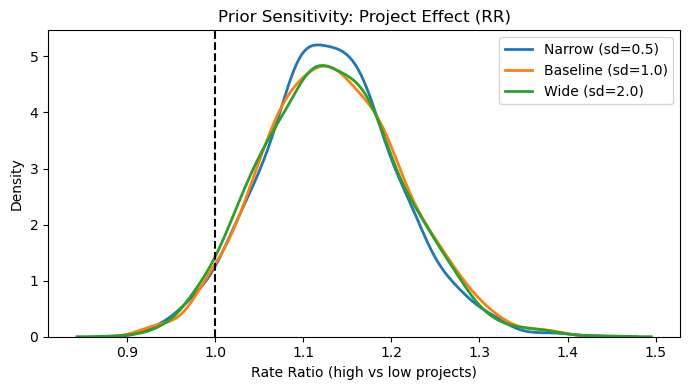

In [73]:
plt.figure(figsize=(7,4))

# Collect posteriors for each prior config
for label, trace in traces.items():   # traces = dict from your loop
    post = trace.posterior["beta_proj"].values.ravel()
    # Convert standardized coefficient to Rate Ratio scale
    rr = np.exp(post * (1/sd_proj))
    sns.kdeplot(rr, fill=False, lw=2, label=label)

plt.axvline(1.0, color="k", linestyle="--")
plt.title("Prior Sensitivity: Project Effect (RR)")
plt.xlabel("Rate Ratio (high vs low projects)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

Posterior estimates of the project effect remain virtually identical under narrow, baseline, and wide priors, demonstrating that the conclusion is robust to prior choice and driven by the data.

# Overall Conclusion (Bayesian Experiments)

Our Bayesian analyses provided a layered perspective on the relationship between projects completed and job offers.

Naive models (unadjusted) suggested a strong positive effect of projects, with posterior rate ratios >2.5.

Adjustment for confounding (internships, networking, soft skills) dramatically reduced the effect, centering the posterior around 1.0 with wide credible intervals, showing that the naive association was largely explained by correlated factors.

Prior sensitivity tests (narrow, baseline, wide) confirmed robustness: conclusions were consistent across different prior choices, indicating results were data-driven rather than prior-driven.

**Takeaway:** While more projects initially appeared to strongly boost job offers, Bayesian adjustment revealed that once key confounders are accounted for, the direct **effect of projects alone is minimal.** This highlights the importance of both skills and networking alongside project experience in job readiness.